# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
import lzma
import numpy as np
import random
import gymnasium as gym
import typing
from metadrive import MetaDriveEnv

from utils.env import State, Observation, Action, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor, get_metadrive_state, next_state, normalize_angle
from utils.transition_model_def import TransitionModel
from utils.idm_model_def import InverseDynamicsModel, idm_train_batch
from utils.model import set_lr_on_step, deviceof
from utils.in_memory_scenario_env import InMemoryScenarioEnv
from utils.loader import getFiles
from utils.waymo_loader import extract_trajectory_file, extract_scenarios_file


from torch.utils.data import TensorDataset, DataLoader
import itertools
import matplotlib.pyplot as plt

# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
file_iter = iter(getFiles(WAYMO_DATA_PATH))
trajectories: list[list[State]] = []

In [3]:
for file_path in file_iter:
    trajectories_in_file = extract_trajectory_file(file_path)
    trajectories.extend(trajectories_in_file)
    print(f"Loaded {len(trajectories_in_file)} trajectories from {file_path}.")

2023-09-08 18:54:27.284248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 18:54:27.304411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-08 18:54:27.304617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loaded 61 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00000-of-01000.
Loaded 72 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00001-of-01000.
Loaded 64 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00002-of-01000.
Loaded 65 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00003-of-01000.
Loaded 65 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00004-of-01000.
Loaded 84 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00005-of-01000.
Loaded 68 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00006-of-01000.
Loaded 65 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00007-of-01000.
Loaded 57 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00008-of-01000.
Loaded 58 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00009-of-01000.
Loaded 72 trajectories from /home/fidget

KeyboardInterrupt: 

In [4]:
# pickle the trajectories
if not os.path.exists('./data/waymo/trajectories.pkl.xz'):
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [3]:
# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'rb') as f:
        trajectories: list[list[State]] = pickle.load(f)

In [4]:
idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append(Observation(states[i], states[i+1]))

# 90:10 train-validation split
idm_train_data = idm_data[:int(len(idm_data)*0.9)]
idm_validation_data = idm_data[int(len(idm_data)*0.9):]

In [5]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 947734
validation data: 105304


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
tm = TransitionModel().to(device)
tm.load_state_dict(torch.load('data/tm.pth'))

<All keys matched successfully>

Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [7]:
idm_train_dataset = TensorDataset(
    obs_batch_to_tensor(idm_train_data, torch.device("cpu")),
    state_batch_to_tensor([o.state for o in idm_train_data], torch.device("cpu")),
    state_batch_to_tensor([o.next_state for o in idm_train_data], torch.device("cpu"))
)
idm_train_loader = DataLoader(idm_train_dataset, batch_size=8192, shuffle=True)
idm_train_iter = itertools.cycle(iter(idm_train_loader))

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [17]:
IDM_LRS = {
    0: 3e-4,
    5000: 1e-4,
    20000: 3e-5,
    25000: 1e-5,
}
IDM_TRAIN_EPOCHS = 25_000

while idm_step < IDM_TRAIN_EPOCHS:
    set_lr_on_step(idm_step, idm_optimizer, IDM_LRS)
    obs_tensor, s0_tensor, s1_tensor = next(idm_train_iter)
    loss = idm_train_batch(
        tm,
        idm,
        idm_optimizer,
        obs_tensor,
        s0_tensor,
        s1_tensor,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 1000 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-1000:])
        print(f"Step: {idm_step}, Loss: {loss:.6f}")

Set learning rate to 0.0003 on step 3792
Step: 4000, Loss: 0.000134
Step: 5000, Loss: 0.000117
Set learning rate to 0.0001 on step 5000
Step: 6000, Loss: 0.000114
Step: 7000, Loss: 0.000113
Step: 8000, Loss: 0.000114


KeyboardInterrupt: 

In [12]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('./data/idm.pth'))    

In [25]:
# save idm
if not os.path.exists('./data/waymo/idm.pth'):
    torch.save(idm.state_dict(), './data/waymo/idm.pth')

: 

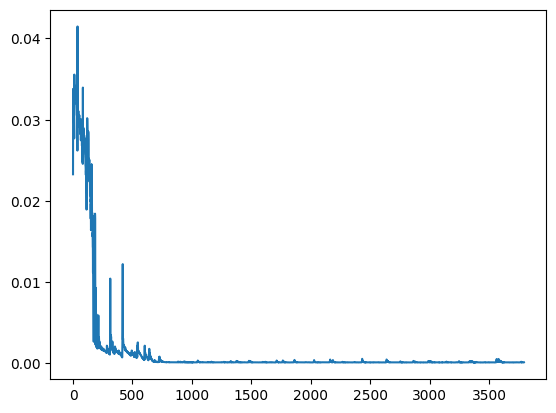

In [11]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

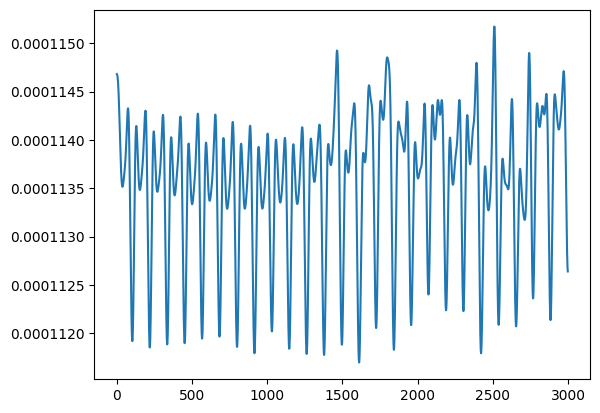

In [18]:
from scipy.ndimage import gaussian_filter1d

# plot the average reward per episode
idm_losses_averaged = gaussian_filter1d(idm_losses[-3000:], sigma=10)
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [13]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([o.state for o in obs_batch], device)
s1_tensor = state_batch_to_tensor([o.next_state for o in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = tm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

KeyboardInterrupt: 

In [14]:
obs_batch = idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([o.state for o in obs_batch], device)
s1_tensor = state_batch_to_tensor([o.next_state for o in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = tm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.000914165168069303


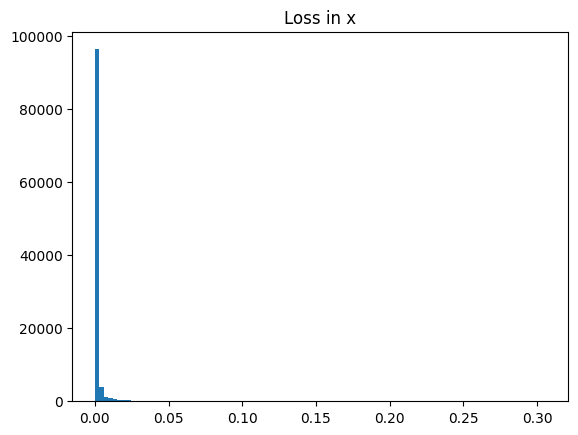

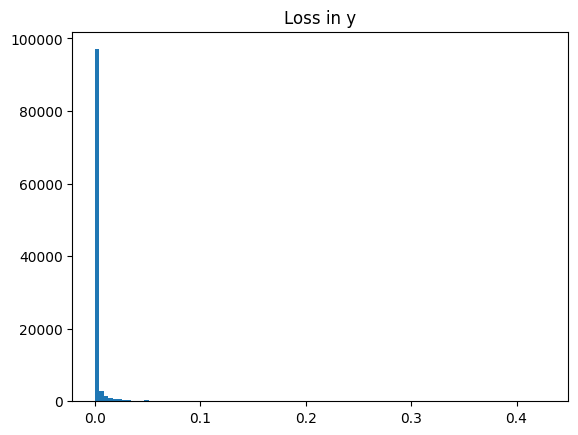

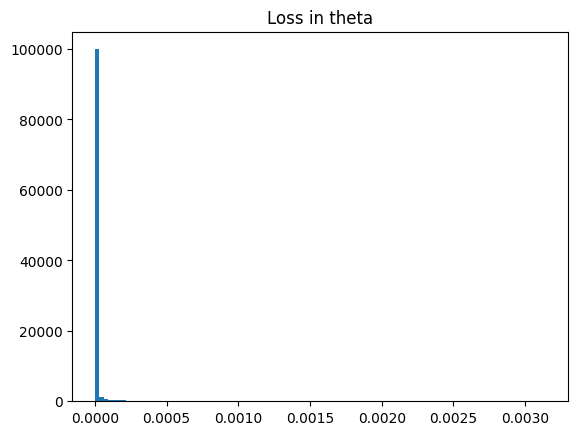

In [15]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


In [16]:
# get outlier indexes
outlier_indexes = np.where((loss_x > 0.1) | (loss_y > 0.1) | (loss_theta > 0.1))[0]

print("outlier indexes", outlier_indexes)
print(len(outlier_indexes))

outlier indexes [  1622   2609   2612  16021  16022  16023  16024  16025  16026  16027
  16028  16029  21638  21639  21640  21641  21642  21643  21644  21645
  24869  24870  24871  24872  24873  24874  24875  24876  24877  24878
  24879  24880  24881  24882  24883  24884  24885  49217  49218  52300
  52334  52335  52336  52337  52338  52339  52340  52341  52342  52343
  52344  52345  52346  52347  52348  55033  55034  55035  55036  55037
  55038  55039  55040  55041  66596  66597  66598  66599  66600  67048
  67049  67050  67051  67052  67053  67054  67055  67056  67057  67058
  67059  67060  67061  67062  67066  67067  67076  67078  67091  67092
  67093  67094  67095  67096  67097  67098  67099  67100  67101  67102
  67117  67118  67119  67120  67121  67122  67123  67124  67125  67126
  67127  67128  67129  67130  67131  67132  67152  67153  67154  67155
  67156  67157  67158  67159  67160  67161  67162  67163  67164  67165
  67166  67167  67168  67671  67672  67673  67674  67675  676

In [17]:
for i in outlier_indexes:
    print("outlier", i)
    print("s0", s0_tensor[i])
    print("s1", s1_tensor[i])
    print("s1_pred", s1_pred[i])
    print("action_pred", action_pred[i])

outlier 1622
s0 tensor([ 13.2424, -12.0192,   0.7409,  -0.6716], device='cuda:0')
s1 tensor([ 12.9812, -11.7822,   0.7409,  -0.6716], device='cuda:0')
s1_pred tensor([ 12.7866, -12.1022,   0.7399,  -0.6744], device='cuda:0')
action_pred tensor([-0.0512, -0.1959], device='cuda:0')
outlier 2609
s0 tensor([-2.0007e-01, -1.9204e+01, -8.5968e-03, -9.9996e-01], device='cuda:0')
s1 tensor([-2.0259e-01, -1.8975e+01, -8.8813e-03, -9.9996e-01], device='cuda:0')
s1_pred tensor([ 1.3035e-01, -1.8882e+01, -4.6170e-03, -1.0006e+00], device='cuda:0')
action_pred tensor([ 0.0307, -0.2071], device='cuda:0')
outlier 2612
s0 tensor([-2.0864e-01, -1.8449e+01, -9.5705e-03, -9.9995e-01], device='cuda:0')
s1 tensor([-2.1069e-01, -1.8240e+01, -9.8406e-03, -9.9995e-01], device='cuda:0')
s1_pred tensor([ 1.4095e-01, -1.8168e+01, -5.3454e-03, -1.0005e+00], device='cuda:0')
action_pred tensor([ 0.0349, -0.1781], device='cuda:0')
outlier 16021
s0 tensor([-2.9433,  6.0487, -0.5059,  0.8626], device='cuda:0')
s1 ten

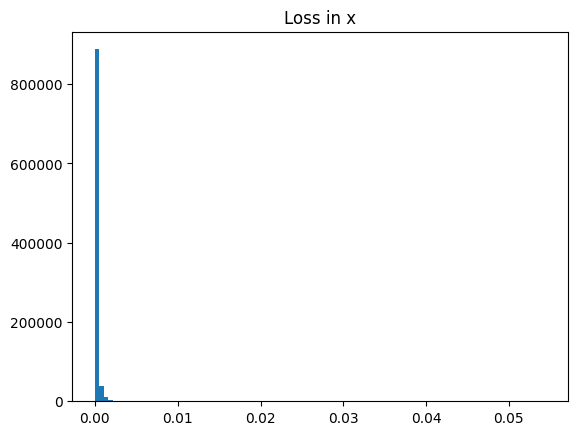

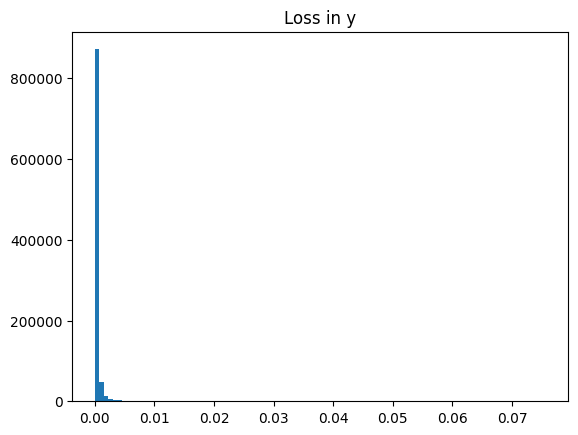

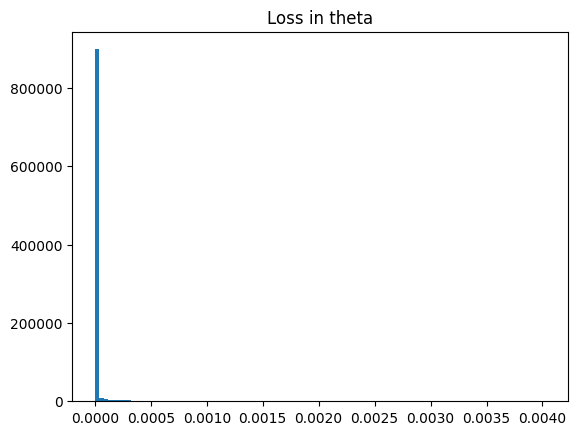

In [24]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [18]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return Action(steering.item(), throttle.item())


### Trajectory Replay

In [29]:
scenarios = extract_scenarios_file(getFiles(WAYMO_DATA_PATH)[0])

2023-09-16 21:39:53.172386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 21:39:53.195216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 21:39:53.195503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [30]:
scenario = scenarios[2]
trajectory = trajectories[2]
# reset
env = InMemoryScenarioEnv(config={"use_render": True, "manual_control": False})
env.set_scenario(scenario)

In [31]:
env.reset()
# set the initial state
for i in range(len(trajectory)):
    st = trajectory[i]
    env.vehicle.set_position(scenario.tracks[scenario.ego_track_index].states[i].position)
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])

[INFO] Assets version: 0.4.1.2
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:device(warning): /dev/input/event20 is not readable, some features will be unavailable.
:device(warning): /dev/input/event21 is not readable, some features will be unavailable.
:device(warning): /dev/input/event22 is not readable, some features will be unavailable.
[WARNING] show_dest_mark and show_line_to_dest are not supported in TrajectoryNavigation (trajectory_navigation.py:34)


97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b42610>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff47de11810>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b41850>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b424d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b59bd0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7ff471b59d90>, entry

### Closed Loop IDM

In [33]:
with torch.no_grad():
    # reset
    env.reset()

    st = trajectory[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(trajectory)-1):
        # st0 = scenario.tracks[scenario.ego_track_index].states[i]
        # st1 =  scenario.tracks[scenario.ego_track_index].states[i]
        st0 = trajectory[i]
        st1 = trajectory[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)(Observation(st0_pred, st1))
        env.step([action.steer, action.throttle])
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f872b949e90>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8624077c90>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8724ce8390>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f87347fc5d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f872b3ae310>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f872b3af610>, entry

### Open Loop IDM

In [32]:
with torch.no_grad():
    # reset
    env.reset()
    st = trajectory[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(trajectory)-1):
        st0 = trajectory[i]
        st1 = trajectory[i+1]
        action = IDMPolicy(idm)(Observation(st0, st1))
        env.step(np.array([action.steer, action.throttle]))
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

97
{'64': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8623a599d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '65': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8623961ad0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '66': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8623cad250>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '67': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8629fcfdd0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '68': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f8727ed5310>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '69': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7f872a231850>, entry

In [34]:
env.close()

In [20]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Render Mode: none


In [21]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(np.array(s_pred.velocity) - np.array(s_true.velocity)) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0 = o.state
    s1 = o.next_state
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(tm:TransitionModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(tm)
    s0 = o.state
    s1 = o.next_state
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = tm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [22]:
import random
random.seed(42)
idm_test_set = random.sample(idm_validation_data, 500)

[INFO] Assets version: 0.4.1.2
:device(warning): /dev/input/event20 is not readable, some features will be unavailable.
:device(warning): /dev/input/event21 is not readable, some features will be unavailable.
:device(warning): /dev/input/event22 is not readable, some features will be unavailable.


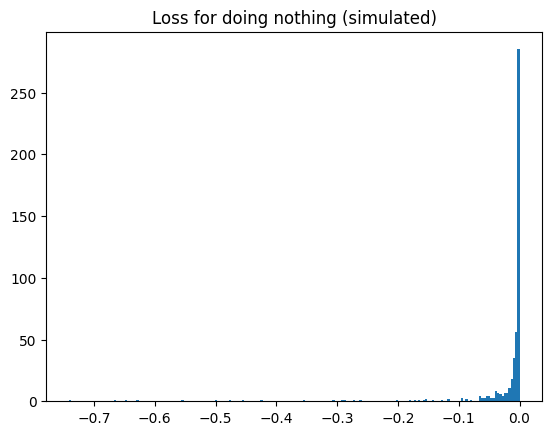

mean -0.025508836099201765
median -0.002425057241775617


In [23]:
def null_policy(_:Observation) -> Action:
    return Action(0, 0)

# test loss function
do_nothing_loss = []
for obs in idm_test_set:
    _, rew, _ = run_game(env, null_policy, obs)
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

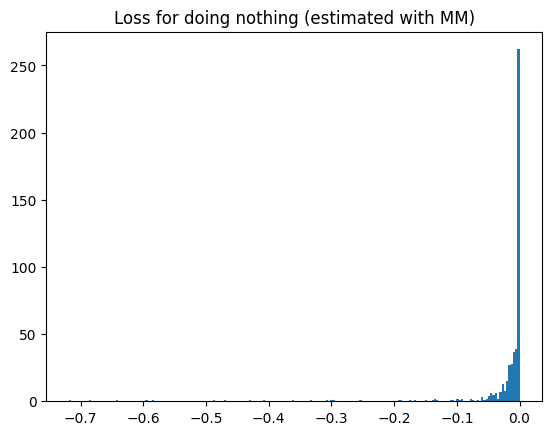

mean -0.02618450143895
median -0.003013399782277795


In [24]:
# test loss function
do_nothing_loss_est = []
for obs in idm_test_set:
    _, rew, pred_s1 = run_game_est(tm, null_policy, obs)
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

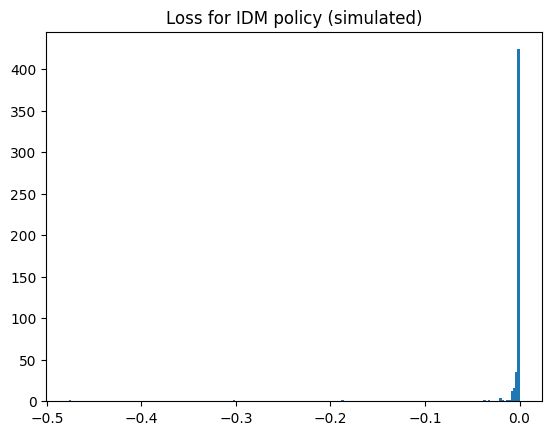

mean -0.0032415838164359815
median -9.599932889507501e-05


In [25]:
# test loss function
idm_loss = []
for o in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), o)
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

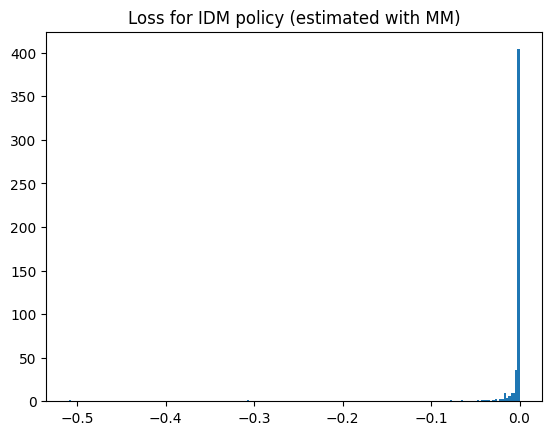

mean -0.004526096828014861
median -0.0003378863615208759


In [26]:
# test loss function
idm_loss_est = []
for o in idm_test_set:
    _, rew, _ = run_game_est(tm, IDMPolicy(idm), o)
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

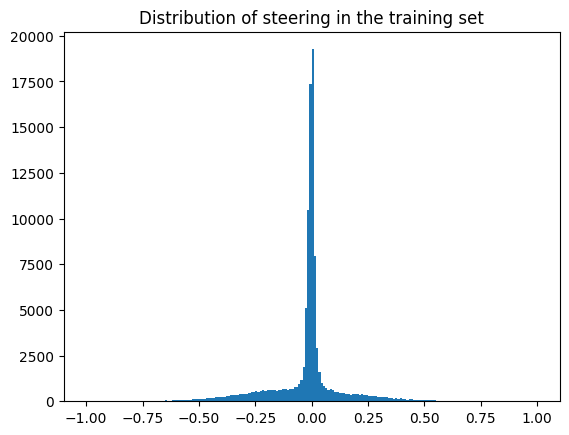

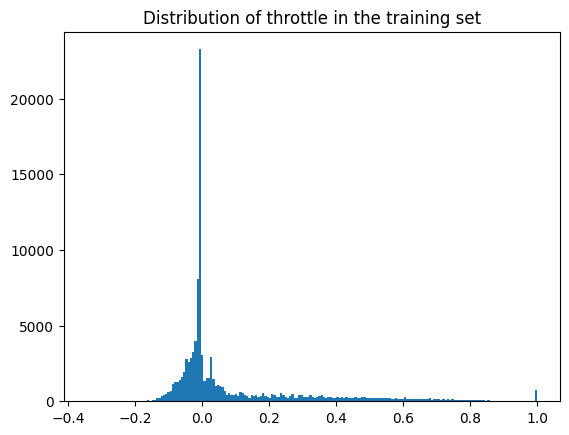

In [27]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()

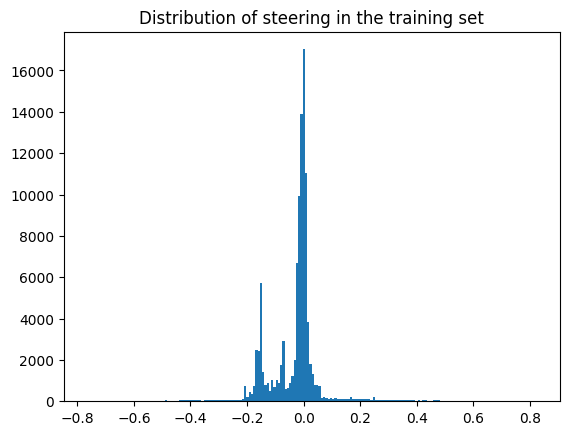

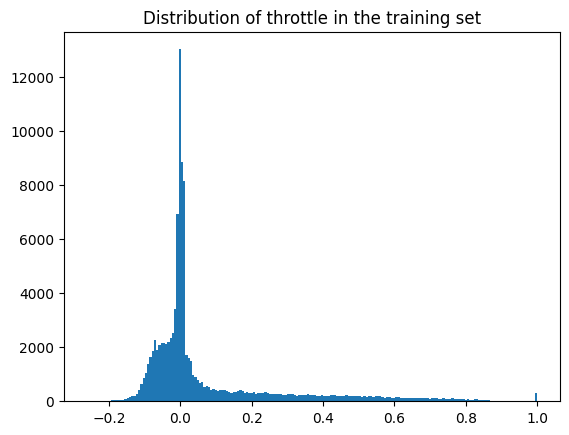

In [48]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()